# [IAPR 2020:][iapr2020] Lab 1 ‒  Image segmentation

**Author:** Sven Borden, Artur Jesslen and Sorya Jullien  
**Due date:** 26.03.2020

[iapr2018]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path = data_base_path)

In [2]:
import numpy as np
import skimage.morphology as morph
import skimage.filters as filt
from skimage.color import rgb2gray
import cv2
from scipy import ndimage
from scipy import signal
from sklearn.cluster import KMeans

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

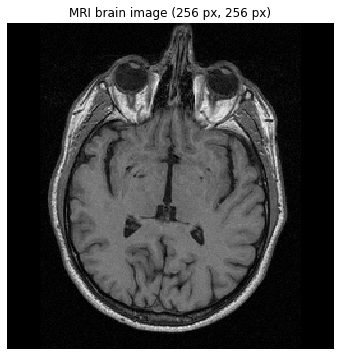

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing

##### ------- Using our algorithm ------

##### Seed selection + initilization

In [4]:
img = brain_im.copy()

# create empty region map
region = np.zeros([im_w,im_h],dtype=np.uint8)

# Seed selection
current_pix = (int(im_h/2), int(im_w/2)+50)

# Parameters
mean_region = float(img[current_pix[1], current_pix[0]])
size = 1
pixel_area = im_h * im_w

contour = []
contour_value = []
dist = 0

threshold = 20

## Using 4-connectivity 
connectivity = [(1, 0), (0, 1), (-1, 0), (0, -1)]

##### Growing procedure

In [5]:
# Homogeinity condition is that the difference between pixels need to be smaller than a given threshold 
while (size < pixel_area) and (dist < threshold):
    ## add pixels
    for i in range(len(connectivity)):
        # For each pixel of the connectivity patern
        temp_pix = [current_pix[0] + connectivity[i][0], current_pix[1] + connectivity[i][1]]
        
        # check if it belongs to image
        belong_img = (im_h > temp_pix[0] > 0) and (im_w > temp_pix[1] > 0)

        # check that it wasn't selected before
        if(belong_img and (region[temp_pix[1], temp_pix[0]] == 0)):
            contour.append(temp_pix)
            contour_value.append(img[temp_pix[1], temp_pix[0]])
            region[temp_pix[1], temp_pix[0]] = 150
    
    # add the nearest pixel of the contour in it
    dist_list = [abs(j - mean_region) for j in contour_value ]
    
    dist = min(dist_list)
    index = dist_list.index(min(dist_list))
    size += 1
    region[current_pix[1], current_pix[0]] = 255
    
    mean_region = (mean_region * size + float(contour_value[index]))/(size+1)
    
    # update seed
    current_pix = contour[index]
    
    del contour[index]
    del contour_value[index]
    

##### ------ Using Library ------

In [6]:
mask = morph.flood(brain_im, seed_point = (int(im_h/2), int(im_w/2)+40), connectivity = 1, tolerance = 20)

#### Comparaison between methods

(-0.5, 255.5, 255.5, -0.5)

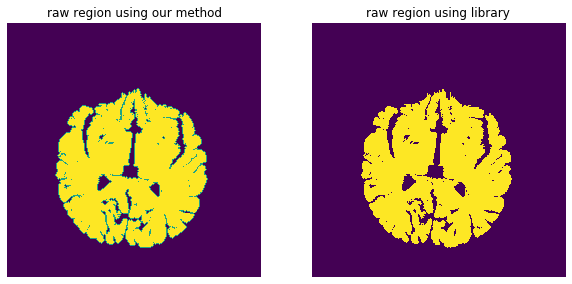

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
axs[0].imshow(region)
axs[0].set_title('raw region using our method')
axs[1].imshow(mask)
axs[1].set_title('raw region using library' )
axs[0].axis('off')
axs[1].axis('off')

Both methods give similar results with the difference that our method need a lot more computation...

#### Morphological operation on the region

In [8]:
region_morph = morph.binary_closing(region, selem=morph.disk(radius = 6))

#### Plotting results

(-0.5, 255.5, 255.5, -0.5)

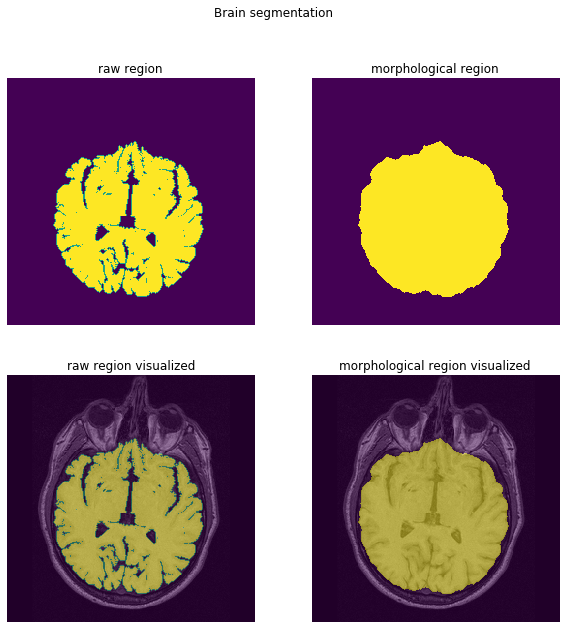

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Brain segmentation')
axs[0,0].imshow(region)
axs[0,0].set_title('raw region')
axs[0,1].imshow(region_morph)
axs[0,1].set_title('morphological region')
axs[1,0].imshow(brain_im, cmap="gray")
axs[1,0].imshow(region, alpha=0.5)
axs[1,0].set_title('raw region visualized')
axs[1,1].imshow(brain_im, cmap="gray")
axs[1,1].imshow(region_morph, alpha=0.5)
axs[1,1].set_title('morphological region visualized')
axs[0,0].axis('off')
axs[1,0].axis('off')
axs[0,1].axis('off')
axs[1,1].axis('off')

#### Size computation

In [10]:
brain_area_raw = np.count_nonzero(region)
brain_area_morph = np.count_nonzero(region_morph)
print('Raw brain area : {:d}px ({:.2f}%)\nMorph brain area: {:d}px ({:.2f}%)'.format(brain_area_raw, brain_area_raw/pixel_area*100, brain_area_morph, brain_area_morph/pixel_area*100))

Raw brain area : 17513px (26.72%)
Morph brain area: 18829px (28.73%)


We know the brain is roughly a circle, so we can approximate the height and width by the diameter of the circle, which we can relate to the area of the disk


In [11]:
brain_diameter_raw = 2*np.sqrt(brain_area_raw/np.pi)
brain_diameter_morph = 2*np.sqrt(brain_area_morph/np.pi)
print('Raw brain diameter : {:.2f}px\nMorph brain diameter : {:.2f}px'.format(brain_diameter_raw, brain_diameter_morph))

Raw brain diameter : 149.33px
Morph brain diameter : 154.83px


### 1.3 Contour detection
Edge detection using **Marr-Hilderth** algorithm

In [12]:
# Defining Laplacian of gaussian using mathematical expression (sum of second derivative of gaussian)
def LoG(x, y, sigma):
    return - (2 - (x**2 + y**2) / (sigma**2))*np.exp(-(x**2+y**2)/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma**3)

In [13]:
# Creating a kernel with adapted size (as function of sigma) of the laplacian of gaussian
def LoG_kernel(sigma = 1):
    size = int(2*(np.ceil(3*sigma))+1)
    x, y = np.meshgrid(np.arange(-size/2, size/2+1), np.arange(-size/2, size/2+1))
    return LoG(x, y, sigma)

In [14]:
# Defining the zero crossing algorithm
def zero_crossing(image):
    zero_crossing = np.zeros_like(image)
    image = image.astype(np.int64)
    # computing zero_crossing
    for i in range(image.shape[0]-1):
        for j in range(image.shape[1]-1):
            # For each zero pixel, its neighbohood must contain a positive AND a negative value to be a zero crossing
            if image[i][j] == 0:
                if (image[i][j-1] < 0 and image[i][j+1] > 0) or (image[i][j-1] < 0 and image[i][j+1] < 0) or (image[i-1][j] < 0 and image[i+1][j] > 0) or (image[i-1][j] > 0 and image[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            # For each negative pixel, its neighbohood must contain a positive value to be a zero crossing 
            if image[i][j] < 0:
                if (image[i][j-1] > 0) or (image[i][j+1] > 0) or (image[i-1][j] > 0) or (image[i+1][j] > 0):
                    zero_crossing[i][j] = 255
    return zero_crossing
        

In [15]:
sigma = 2
# Using 2 methods to compare
# First method : Canny edge (given in the cv2 library)
contoured = cv2.Canny(brain_im, 100, 200)
# Second method : Convolution of laplacian of gaussian kernel with image
# followed by the zero crossing algorithm to find the edges
laplacGauss = LoG_kernel(sigma)
contoured2 = signal.convolve(brain_im, laplacGauss, mode='same')
contoured2_zc = zero_crossing(contoured2)


(-0.5, 255.5, 255.5, -0.5)

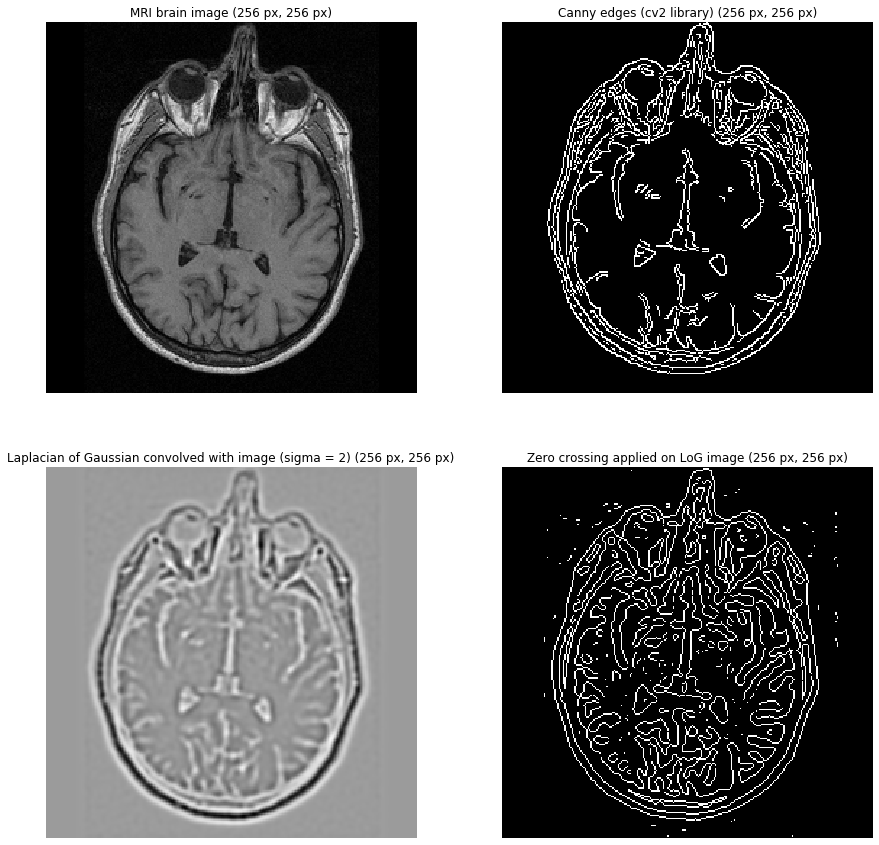

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0,0].imshow(brain_im, cmap='gray')
ax[0,0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[0,0].axis('off')
ax[0,1].imshow(contoured, cmap='gray')
ax[0,1].set_title('Canny edges (cv2 library) ({} px, {} px)'.format(im_h, im_w))
ax[0,1].axis('off')
ax[1,0].imshow(contoured2, cmap='gray')
ax[1,0].set_title('Laplacian of Gaussian convolved with image (sigma = {:d}) ({} px, {} px)'.format(sigma, im_h, im_w))
ax[1,0].axis('off')
ax[1,1].imshow(contoured2_zc, cmap='gray')
ax[1,1].set_title('Zero crossing applied on LoG image ({} px, {} px)'.format(im_h, im_w))
ax[1,1].axis('off')

As we can see on the previous images, the Marr-Hilderth algorithm is very powerful to show the edges.  
Some edges are better represented by the Marr-Hilderth algorithm compared to the Canny edges

#### Brain size evaluation

In [17]:
from scipy.spatial.distance import cdist

def reduce_noise(img, keep_percent = 0.9, PLOT = True):
    copy = img.copy()

    # extract indices of points
    contours = np.argwhere(copy != 0)
    image_center = np.array([[np.mean(contours[:,0]), np.mean(contours[:,1])]])

    # compute distance to the center of the image
    dist = cdist(contours, image_center).ravel()
    n_items = dist.shape[0]
    # only keep % of items to remove extra points out of the brain shape
    n_items_keep = int(keep_percent*n_items)
    extracted_contours = contours[np.argsort(dist)[0:n_items_keep], :]
    
    if PLOT:
        plt.figure(figsize=(5, 5))
        plt.scatter(extracted_contours[:,1], extracted_contours[:,0], s=1)
        plt.xlim(0, 256)
        plt.ylim(0, 256)
        plt.gca().invert_yaxis()
    return extracted_contours

#def compute_size(contour):
#    mean = np.array([[np.mean(contour[:,0]), np.mean(contour[:,1])]])
#    dist = cdist(contour, mean).ravel()    
#    return dist.max()


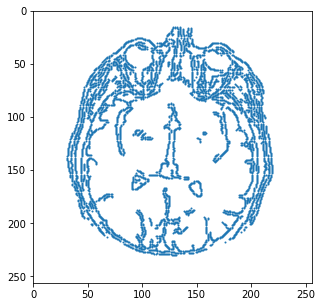

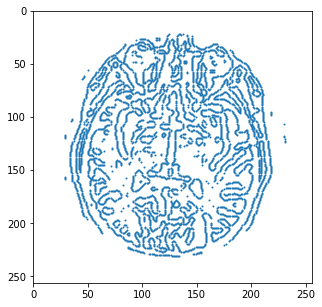

In [18]:
# Canny Edge
contours_canny = reduce_noise(contoured, PLOT=True)
#radius_canny = compute_size(contours_canny)

# Our Implementation
contours_custom = reduce_noise(contoured2_zc, PLOT=True)
#radius_custom = compute_size(contours_custom)

#brain_area_canny = np.pi*(radius_canny**2)
#brain_area_custom = np.pi*(radius_custom**2)

#brain_diameter_canny = 2*radius_canny
#brain_diameter_custom = 2*radius_custom

#print('Canny Contour Detection Area : {:.2f}px'.format(brain_area_canny))
#print('Custom Contour Detection Area : {:.2f}px'.format(brain_area_custom))

#print('Contour Detection Diameter : {:.2f}px'.format(brain_diameter_canny))
#print('Custom Detection Diameter : {:.2f}px'.format(brain_diameter_custom))

As the results are not that good because it is hard to get rid of the front part of the head with this method, we could use some morphological operators and filling the inner part to have the brain shape : 

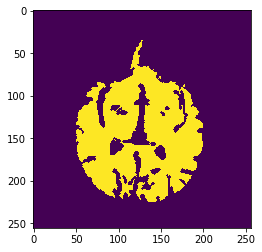

In [19]:
brain_countour = morph.dilation(contoured, selem=morph.disk(radius = 1))
brain_seg = morph.flood(brain_countour, seed_point = (int(contoured.shape[0]/2), int(contoured.shape[1]/2)+40))
plt.imshow(brain_seg)

### Calculate size :

In [21]:
brain_area_contour = np.count_nonzero(brain_seg)
brain_diameter_contour = 2*np.sqrt(brain_area_contour/np.pi)
print('Brain area : {:d}px ({:.2f}%)'.format(brain_area_contour, brain_area_contour/pixel_area*100))


Brain area : 14762px (22.53%)


#### Simpler version for brain detection using only a threshold followed by mathematical morphology operators

In [22]:
# Threshold function
def threshold(img, th1 = None, th2 = None):
    out = np.ones(np.shape(img))
    if th1 is not None:
        out[np.where(img < th1)] = 0
    if th2 is not None:
        out[np.where(img > th2)] = 0
    return out

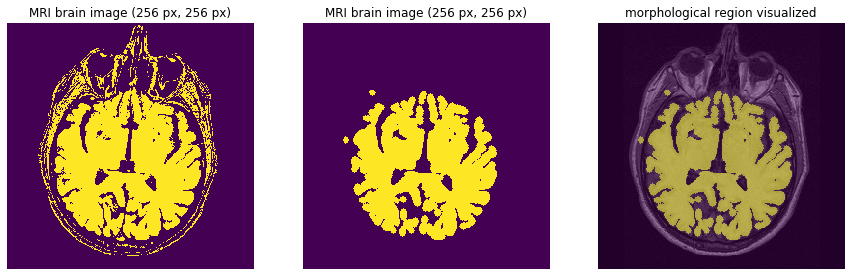

In [23]:
# Thresholding operation
img_threshold = threshold(brain_im, 60, 100)

# Mathematical morphology
img_morph = morph.binary_opening(img_threshold, selem=morph.disk(3))
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(img_threshold)
ax[0].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(img_morph)
ax[1].set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
ax[2].imshow(brain_im, cmap="gray")
ax[2].imshow(img_morph, alpha=0.5)
ax[2].set_title('morphological region visualized')
ax[2].axis('off')
plt.show()

We can also use some simple morphological operators and a threshold to detect the brain part on the image. It needs a lot less computation than the the growing algorithm but is not as powerful. For a lot of application, this method is sufficiently precise.

### Comparaison of Region growing Contour Detection and Threshold

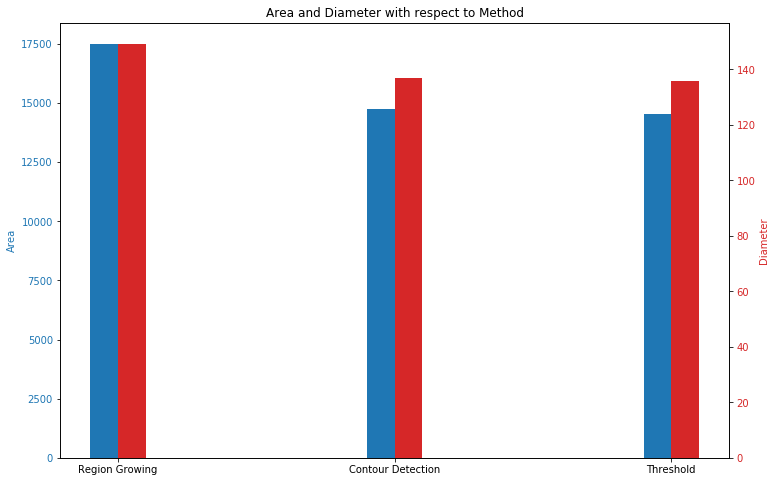

In [24]:
brain_area_threshold = np.count_nonzero(img_morph)
brain_diameter_threshold = 2*np.sqrt(brain_area_threshold/np.pi)

#PLOT
names = ['Region Growing', 'Contour Detection', 'Threshold']
y_pos = np.arange(len(names))

# Area and diameter comparaison chart
performance_area = [brain_area_raw, brain_area_contour, brain_area_threshold]
performance_diameters = [brain_diameter_raw, brain_diameter_contour, brain_diameter_threshold]

fig, ax1 = plt.subplots(figsize=(12, 8))
color = 'tab:blue'
plt.xticks(y_pos, names)
plt.ylabel('Area', color=color)
plt.bar(y_pos, performance_area, align='center', width=0.2, color=color, fill=True, alpha=1)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
plt.ylabel('Diameter', color=color)
plt.bar(y_pos, performance_diameters, align='edge', width=0.1, color=color,fill=True, alpha=1)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Area and Diameter with respect to Method')
plt.show()

As we can observe from those data, there is a circa 10% difference between the two method, but the compute time is far more efficient with the Threshold method (2 order of magnitudes of differences). 

## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color.
2. Compute the total area (in pixels) of each color.

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

**Note:** the routine(s) that you will write for this exercise will be useful for the final project as well, so pay special attention to it.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

In [ ]:
def normalization(img):
    _min = img.min()
    _max = img.max()
    return img - _min / (_max - _min)

In [ ]:
# Computing a threshold to isolate foreground from foreground
images_gray = np.zeros((images.shape[0], images.shape[1], images.shape[2]))
images_threshold = np.zeros(images_gray.shape)
for i in range(images.shape[0]):
    images_gray[i,:,:] = rgb2gray(images[i,:,:,:])
    # We are using an adaptative threshold that find the best threshold depeding of the illumination
    t = filt.threshold_otsu(images_gray[i,:,:])
    images_threshold[i,:,:] = threshold(images_gray[i,:,:], t)

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images_threshold, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color


In [ ]:
# Function to check if a neighbor has label, if yes, it will return the label
def check(list, val): 
    # traverse in the list 
    for x_list in list: 
        # compare with all the values 
        # with val 
        if val > x_list and x_list > 0: 
            return x_list 
    return False

In [ ]:
# Return an image with element corresponding to the given label
def labeling(img, label):
    out = np.zeros(np.shape(img), dtype = np.uint)
    out[np.where(img == label)] = 1
    return out

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
labels = []
# Iterating on every images
for ax, image_thres, name in zip(axes.ravel(), images_threshold, im_names):
    new_label = 1
    im_h = image_thres.shape[0] 
    im_w = image_thres.shape[1]

    label = np.zeros(image_thres.shape, dtype=np.uint)
    
    # Iterating on each pixels of the image
    for i in range(1, im_h-1):
        for j in range(1, im_w-1):
            # Labeling each pixels of the foreground with same value as its neighbor
            if image_thres[i,j] == 0:
                label_neighbors = np.max([label[i-1,j+1], label[i-1,j-1], 
                                          label[i-1,j], label[i,j-1]])
                if label_neighbors != 0:
                    label[i,j] = label_neighbors
                else:
                    label[i,j] = new_label+1
                    new_label += 1
                    
    # Merging of labels for objects that are containing different labels
    label2 = label
    for i in range(1, im_h-1):
        for j in range(1, im_w-1):
            label_neighbors = [label2[i-1,j+1], label2[i,j+1], 
                               label2[i+1,j+1], label2[i-1,j], 
                               label2[i+1,j], label2[i-1,j-1], 
                               label2[i,j-1], label2[i+1,j-1]]
            val_min = check(label_neighbors,label2[i,j])
            if check(label_neighbors,label2[i,j]):
                label2[np.where(label2 == label2[i,j])] = val_min

    ax.imshow(label2)
    ax.set_title(name)
    labels.append(label2)

    label_unique = np.unique(label2)
    # Background is not an object so we subtract 1
    nb_objects = len(label_unique) - 1

    print('{} : There are {:d} objects.'.format(name, nb_objects))

In [ ]:
object_class = []
for image, label, name in zip(images, labels, im_names):
    # count nb of objects of different colors
    object_color = np.zeros((nb_objects, images.shape[-1]))
    
    # Define biggest difference beteween colors
    other_class_idx = 0
    
    for i in range(nb_objects):
        # Define an image with colors of objects
        object_colored = np.array(labeling(label, np.unique(label)[i+1]))[:,:,None]*np.array(image)
        
        # Define mean color of object
        for channel in range(images.shape[-1]):
            object_color[i, channel] = object_colored[object_colored[:,:,channel] != 0, channel].mean()

    # Classification of colors using kmeans algorithm
    kmeans = KMeans(n_clusters=2).fit(object_color)
    object_class.append(kmeans.labels_)
    
    print('{} : There are {} shapes of color 1.\n                  There are {} shapes of color 2.'.format(name,len(kmeans.labels_)-np.count_nonzero(kmeans.labels_),np.count_nonzero(kmeans.labels_)))
    

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [ ]:
total_pixels = im_h*im_w
for label_matrix, name, obj_class in zip(labels, im_names, object_class):
    nb_pixels1 = 0
    nb_pixels2 = 0

    for i in range(nb_objects):
        # Find where pixels of objects are
        obj = labeling(label, np.unique(label)[i+1])
        if obj_class[i] == 0:
            nb_pixels1 += obj.sum()
        else:
            nb_pixels2 += obj.sum()

    print('{} : Color 1 area : {:d}px ({:.2f}% of the image)\n                  Color 2 area : {:d}px ({:.2f}% of the image)'.format(name, int(nb_pixels1), nb_pixels1/total_pixels*100, int(nb_pixels2), nb_pixels2/total_pixels*100))
